# SparseEdges : including prior information


Using prior information in the edge extraction


Table of content

* [A dipole as a second-order prior](#A-dipole-as-a-second-order-prior)
* [Prior on second-order distribution of edge co-occurences](#Prior-on-second-order-distribution-of-orientations)
* [Application to segmentation](#Application-to-segmentation)


## Initialization

In [1]:
from __future__ import division, print_function
import matplotlib
#matplotlib.rcParams.update({'font.size': 18, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})
matplotlib.rcParams.update({'text.usetex': False})
%matplotlib inline
#%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt

import numpy as np
np.set_printoptions(precision=4)#, suppress=True)

FORMATS = ['pdf', 'eps']

In [2]:
#! defining framework
#!-------------------
from SparseEdges import SparseEdges
mp = SparseEdges('https://raw.githubusercontent.com/meduz/SparseEdges/master/default_param.py')
#pe.N = 4
#pe.do_mask=False
#pe.MP_alpha=1.
#pe.do_whitening = False

print ('Range of spatial frequencies: ', mp.sf_0)

Range of spatial frequencies:  [ 0.618   0.382   0.2361  0.1459  0.0902  0.0557  0.0344  0.0213  0.0132
  0.0081  0.005 ]


In [3]:
print ('Range of angles: ', mp.theta*180./np.pi)

Range of angles:  [-82.5 -75.  -67.5 -60.  -52.5 -45.  -37.5 -30.  -22.5 -15.   -7.5   0.
   7.5  15.   22.5  30.   37.5  45.   52.5  60.   67.5  75.   82.5  90. ]


## A dipole as a second-order prior

### constructing the dipole step by step

Let's contruct a dipole step by step.

A dipole is defined by a reference edge, given by its position, orientationand scale, and by the probability associated to this reference.

First, we define the relative difference of orientation $\psi$:

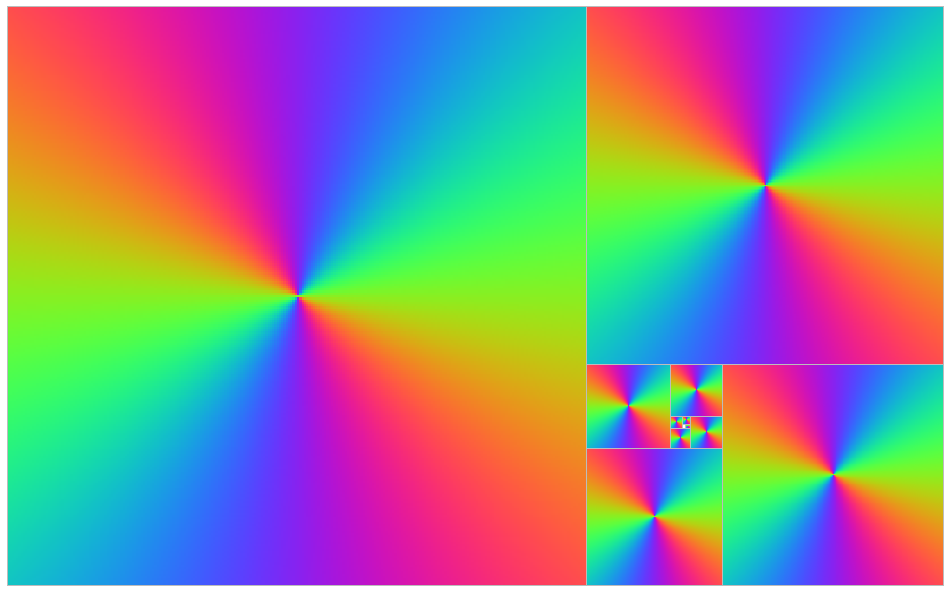

In [4]:
def plot_dipole( w=.25, B_psi=.5, B_theta=.5, scale=1.5, epsilon=1.e-6):
    x, y, theta_edge, sf_0, C, phase = mp.N_X/2, mp.N_Y/2, mp.theta[-1], mp.sf_0[2], 1, 0.
    D = np.ones((mp.N_X, mp.N_Y, mp.pe.n_theta, mp.n_levels))
    for i_sf_0, sf_0_ in enumerate(mp.sf_0):
        for i_theta, theta_layer in enumerate(mp.theta):
            psi = np.arctan2(mp.Y-y, mp.X-x) - theta_layer #- theta_edge + theta/2 - np.pi/4
            psi = ((psi + np.pi/2  - np.pi/mp.pe.N_phi/2 ) % (np.pi)) - np.pi/2  + np.pi/mp.pe.N_phi/2
            D[:, :, i_theta, i_sf_0] = np.exp((np.cos(2*psi)-1.)/(B_psi**2))
    mp.golden_pyramid(D)
plot_dipole()

Now we add difference of orientation $\theta$

0.0
-0.00140431596367 -2.47436291259e-20 1.0


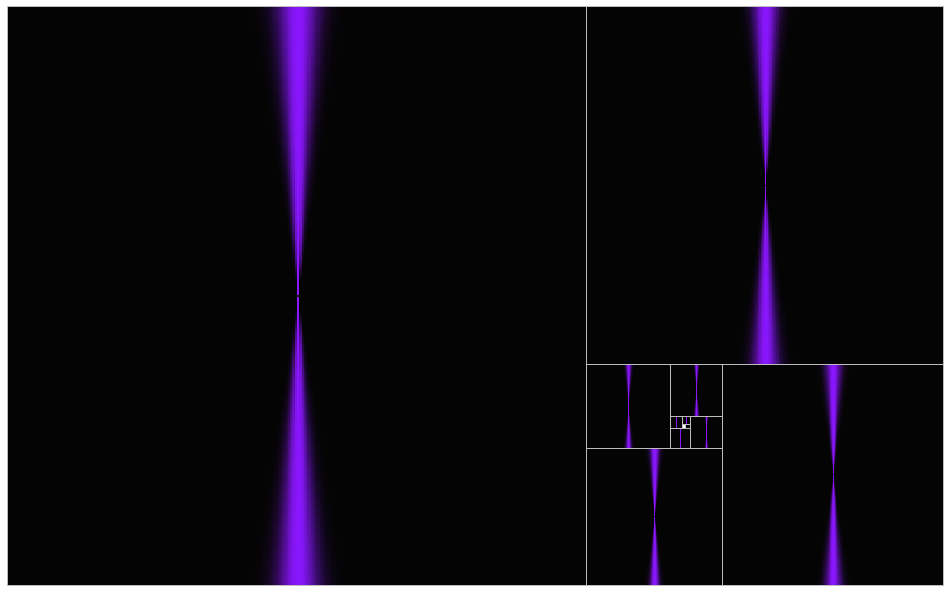

In [5]:
def plot_dipole(w=mp.pe.dip_w, B_psi=mp.pe.dip_B_psi, B_theta=mp.pe.dip_B_psi, scale=mp.pe.dip_B_psi, epsilon=mp.pe.dip_epsilon):
    x, y, theta_edge, sf_0, C, phase = mp.N_X/2, mp.N_Y/2, mp.theta[-1], mp.sf_0[2], 1, 0.
    theta_edge = np.pi/2 - theta_edge
    #theta_edge = ((theta_edge + np.pi/2 - np.pi/mp.pe.n_theta/2)  % (np.pi) ) - np.pi/2  + np.pi/mp.pe.n_theta/2
    print (theta_edge*180/np.pi)
    D = np.ones((mp.N_X, mp.N_Y, mp.pe.n_theta, mp.n_levels))
    for i_sf_0, sf_0_ in enumerate(mp.sf_0):
        for i_theta, theta_layer in enumerate(mp.theta):
            theta_layer = np.pi/2 - theta_layer
            theta_layer = ((theta_layer + np.pi/2 - np.pi/mp.pe.n_theta/2)  % (np.pi) ) - np.pi/2  + np.pi/mp.pe.n_theta/2
            theta = theta_layer - theta_edge # angle between edge's orientation and the layer's one
            psi = np.arctan2(mp.Y-y, mp.X-x) - theta_edge -np.pi/2 - theta/2 #- np.pi/4
            #print i_theta, theta*180/np.pi
            #psi = ((psi + np.pi/2  - np.pi/mp.pe.N_phi/2 ) % (np.pi)) - np.pi/2  + np.pi/mp.pe.N_phi/2
            D[:, :, i_theta, i_sf_0] = np.exp((np.cos(2*(psi))-1.)/(B_psi**2))
            D[:, :, i_theta, i_sf_0] *= np.exp((np.cos(2*theta)-1.)/(B_theta**2))
    D -= D.mean()
    D /= np.abs(D).max()
    
    print (D.min(), D.mean(), D.max())
    mp.golden_pyramid(D)
plot_dipole()

Now we modulate it according to distance $d$ and scale to obtain the final dipole as implemented in ``SparseEdges``:

0.0
-3.1057506945e-05 6.57541409887e-20 1.0


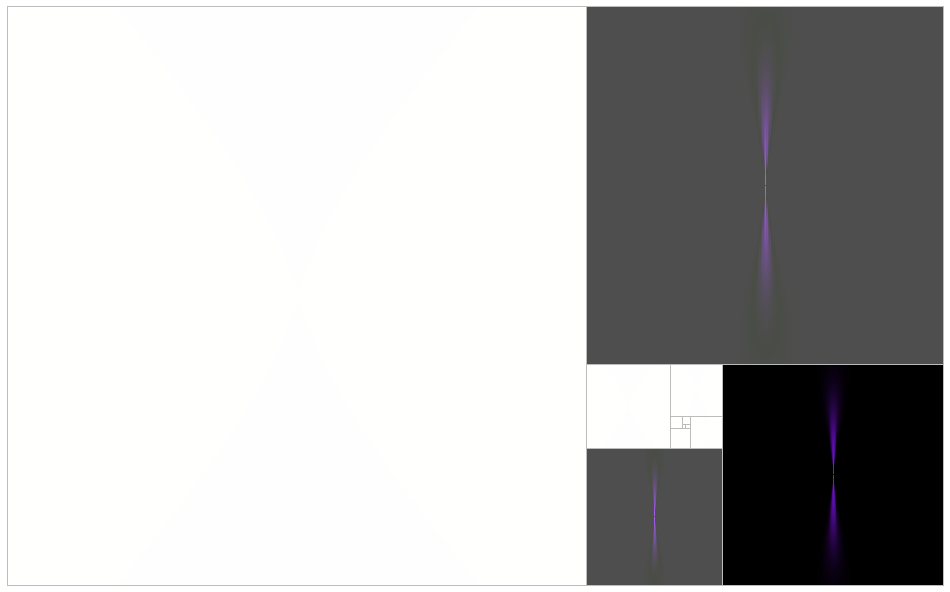

In [6]:
def plot_dipole(w=mp.pe.dip_w, B_psi=mp.pe.dip_B_psi, B_theta=mp.pe.dip_B_psi, scale=mp.pe.dip_B_psi, epsilon=mp.pe.dip_epsilon):
    x, y, theta_edge, sf_0, C, phase = mp.N_X/2., mp.N_Y/2., mp.theta[-1], mp.sf_0[2], 1, 0.
    theta_edge = np.pi/2 - theta_edge
    print( theta_edge*180/np.pi)
    D = np.zeros((mp.N_X, mp.N_Y, mp.pe.n_theta, mp.n_levels))
    distance = np.sqrt(((mp.X-x)**2+(mp.Y-y)**2)/(mp.N_X**2+mp.N_Y**2))/w
    #print distance.max()
    neighborhood = np.exp(-distance**2)
    for i_sf_0, sf_0_ in enumerate(mp.sf_0):
        for i_theta, theta_layer in enumerate(mp.theta):
#                                if self.pe.scale_invariant: d *= np.sqrt(Sf_0[:, np.newaxis]*Sf_0[np.newaxis, :])#*np.sqrt(self.N_X)
            theta_layer = np.pi/2 - theta_layer
            theta_layer = ((theta_layer + np.pi/2 - np.pi/mp.pe.n_theta/2)  % (np.pi) ) - np.pi/2  + np.pi/mp.pe.n_theta/2
            theta = theta_layer - theta_edge # angle between edge's orientation and the layer's one
            psi = np.arctan2(mp.Y-y, mp.X-x) - theta_edge -np.pi/2 - theta/2 #- np.pi/4

            d = distance + epsilon
            D[:, :, i_theta, i_sf_0] = np.exp((np.cos(2*(psi))-1)/(B_psi**2 * d))#/(B_psi*np.sqrt(d))
            D[:, :, i_theta, i_sf_0] *= np.exp((np.cos(2*theta)-1)/(B_theta**2 * d))/(B_theta*np.sqrt(d))
#        D[:, :, :, i_sf_0] /= D[:, :, :, i_sf_0].mean()
#        D[:, :, :, i_sf_0] -= 1.
        D[:, :, :, i_sf_0] *= neighborhood[:, :, np.newaxis] * np.exp(-np.abs( np.log2(mp.sf_0[i_sf_0] / sf_0)) / scale)
#        D[:, :, :, i_sf_0] += 1.
    D -= D.mean()
    D /= np.abs(D).max()
    
    print (D.min(), D.mean(), D.max())

    mp.golden_pyramid(np.log2(1.+D))
plot_dipole()

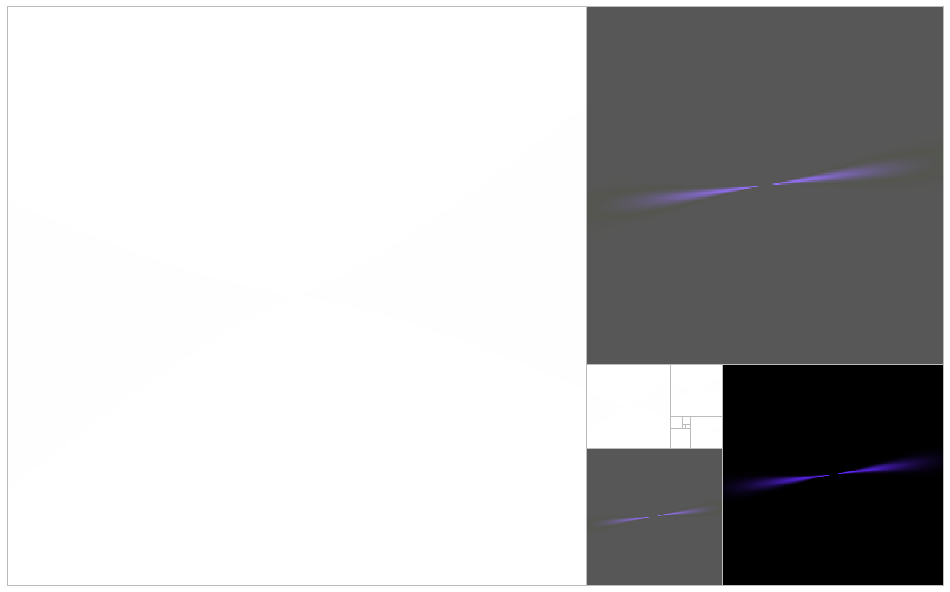

In [7]:
def plot_dipole(w=mp.pe.dip_w, B_psi=mp.pe.dip_B_psi, B_theta=mp.pe.dip_B_psi, scale=mp.pe.dip_B_psi, epsilon=mp.pe.dip_epsilon):
    mp.pe.dip_w = w
    mp.pe.dip_B_psi=B_psi
    mp.pe.dip_B_theta=B_theta
    mp.pe.dip_scale=scale
    mp.pe.dip_epsilon=epsilon
    logD = mp.dipole(np.array([mp.N_X/2, mp.N_Y/2, mp.theta[0], mp.sf_0[2], 1, 0.]))
    mp.golden_pyramid(logD)
#plot_dipole()
from IPython.html.widgets import interact
_ = interact(plot_dipole, w=(.0, .3, .0001), B_psi=(0.01, 2., 0.04), B_theta=(0.01, 2., 0.04), scale=(0.01, 20., .04), epsilon=(0, 1, 0.1))

co-circular axis of same angle are aligned.

### testing with a simple image of 2 edges

In [8]:
import matplotlib
#matplotlib.rcParams.update({'font.size': 18, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})
matplotlib.rcParams.update({'text.usetex': False})
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt

import numpy as np
np.set_printoptions(precision=4)#, suppress=True)
# http://ipython.org/ipython-doc/stable/config/extensions/autoreload.html
#%load_ext autoreload
#%autoreload 2

# where should we store the figures generated by this notebook
FORMATS = ['pdf', 'eps']

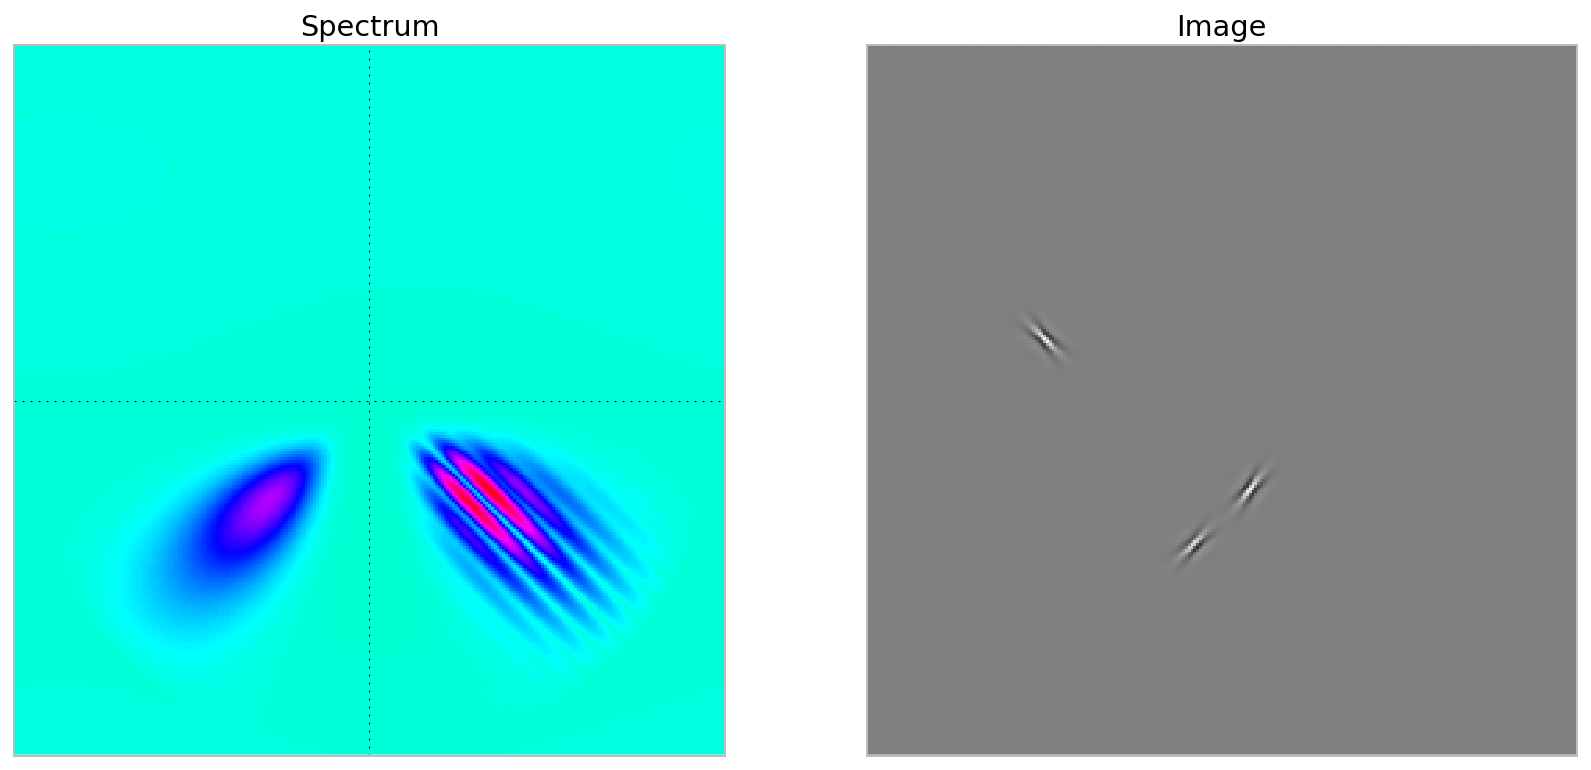

In [9]:
mp = SparseEdges('default_param.py')

# filters in Fourier space
edge_in, edge_bis, edge_ter = [mp.N_X*.5-10+42, mp.N_Y*.5+10, 18, 2], [mp.N_X*.5+42+10, mp.N_Y*.5-10, 17, 2], [mp.N_X*.25+42, mp.N_Y*.25, 5, 2]
FT_lg_in = mp.loggabor(edge_in[0], edge_in[1], 
                       theta= mp.theta[edge_in[2]], B_theta=mp.pe.B_theta,
                       sf_0=mp.sf_0[edge_in[3]],  B_sf=mp.pe.B_sf)
FT_lg_bis = mp.loggabor(edge_bis[0], edge_bis[1], 
                        theta= mp.theta[edge_bis[2]], B_theta=mp.pe.B_theta,
                        sf_0=mp.sf_0[edge_bis[3]], B_sf=mp.pe.B_sf)
FT_lg_ter = mp.loggabor(edge_ter[0], edge_ter[1], 
                        theta= mp.theta[edge_ter[2]], B_theta=mp.pe.B_theta,
                        sf_0=mp.sf_0[edge_ter[3]], B_sf=mp.pe.B_sf)
# mixing both and shows one
FT_lg_ = 42. *  FT_lg_in + 35.*np.exp(1j*np.pi/4.) * FT_lg_bis + 40. *  FT_lg_ter
fig = mp.show_FT(FT_lg_)

In [10]:
image = mp.invert(FT_lg_)
mp.pe.do_whitening = False
mp.pe.N = 5
mp.pe.MP_alpha = 1.

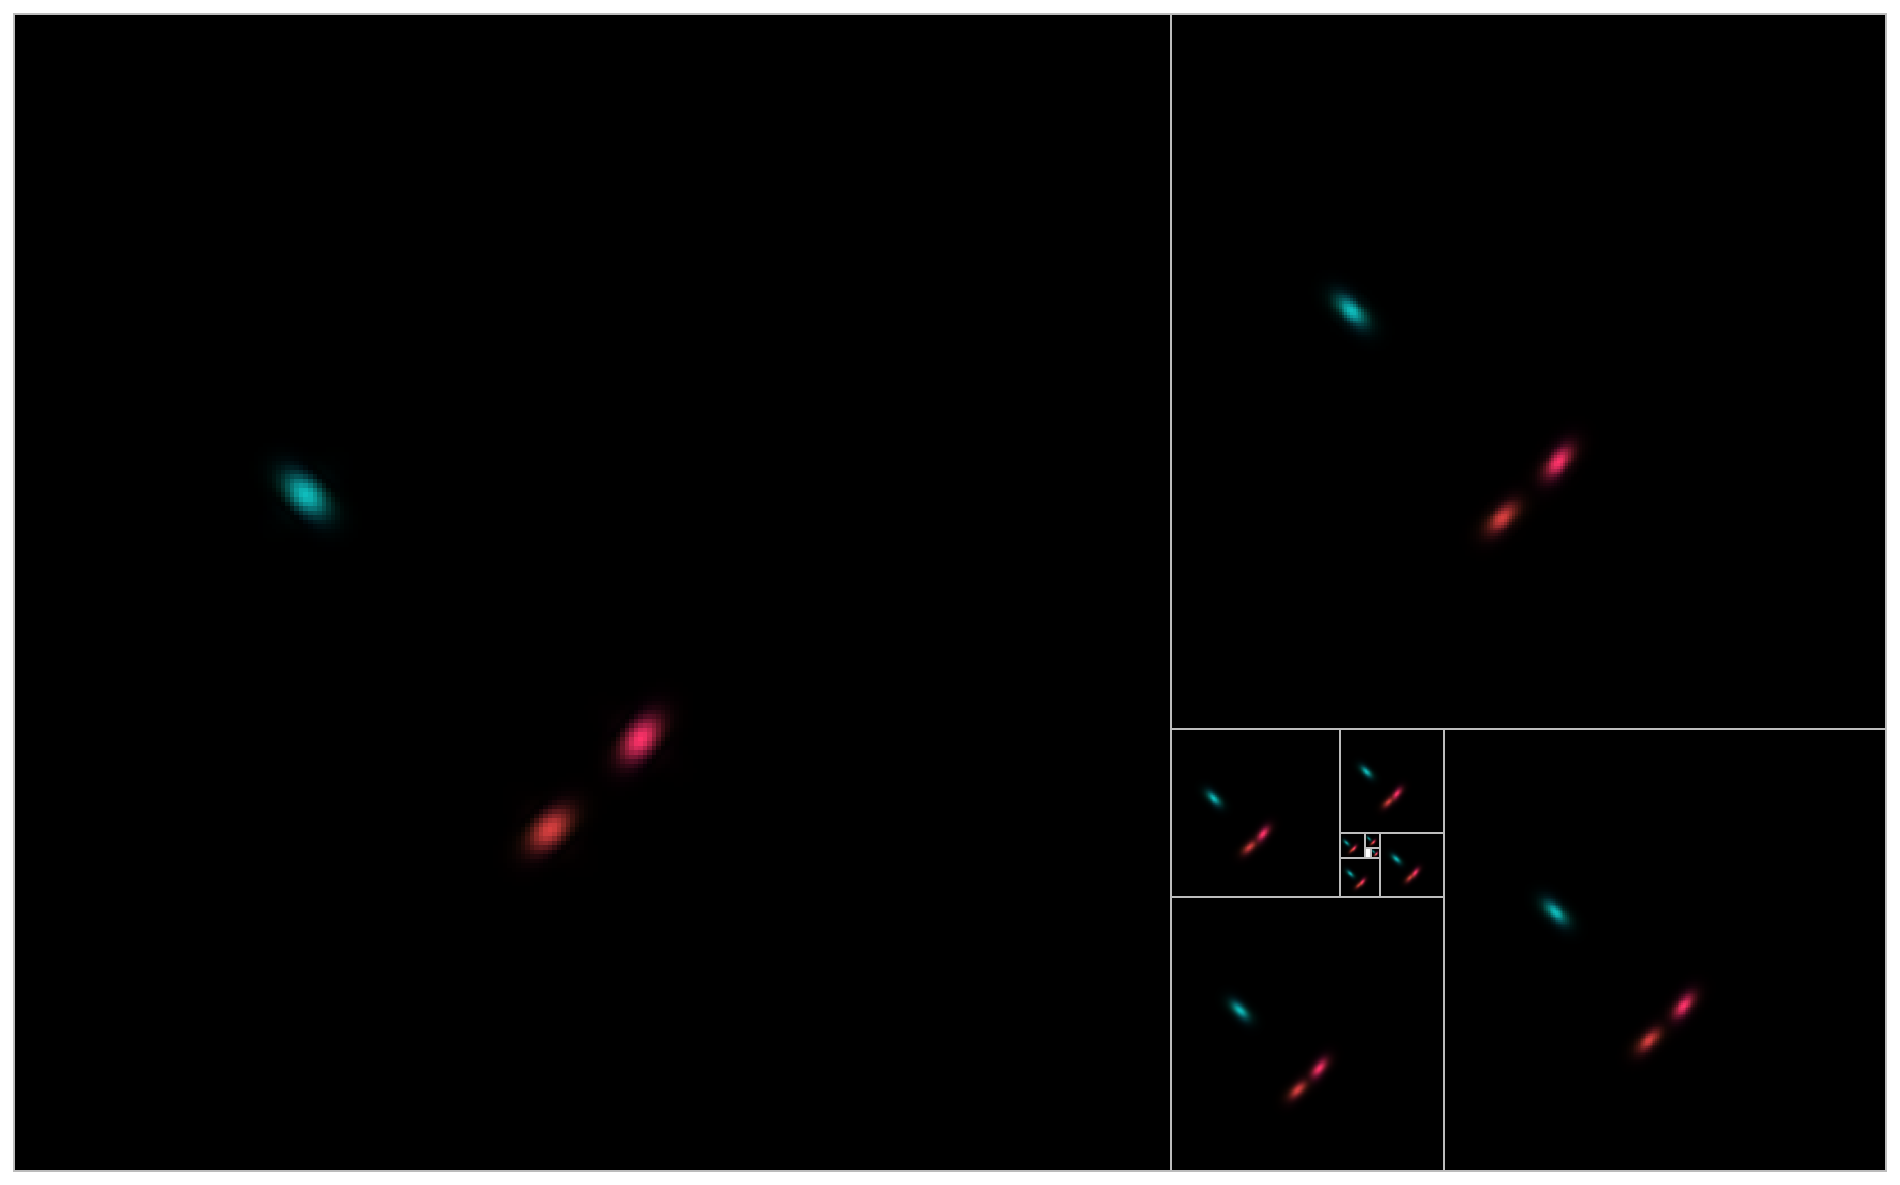

In [11]:
z = np.ones((mp.N_X, mp.N_Y, mp.pe.n_theta, mp.n_levels))
for i_sf_0, sf_0_ in enumerate(mp.sf_0):
    for i_theta, theta in enumerate(mp.theta):
        params = {'sf_0':sf_0_, 'B_sf':mp.pe.B_sf, 'theta':theta, 'B_theta':mp.pe.B_theta}
        # loggabor takes as args: u, v, sf_0, B_sf, theta, B_theta)
        FT_lg = mp.loggabor(0, 0, **params)
        z[:, :, i_theta, i_sf_0] = np.absolute(mp.FTfilter(image, FT_lg, full=True))

fig = mp.golden_pyramid(z)

In [12]:
print (' without second-order ')
mp.pe.eta_SO = 0.
edges, C_res = mp.run_mp(image, verbose=True)

 without second-order 
Edge

[ 20 %] elapsed[sec]: 0.836 | ETA[sec]: 3.346 

 0 / 5  - Max activity  :  41.9773763607  phase=  0.0332324914571  deg,  @  (160, 138, 18, 2)
Edge

[ 40 %] elapsed[sec]: 4.824 | ETA[sec]: 7.236 

 1 / 5  - Max activity  :  40.0  phase=  2.40762543886e-13  deg,  @  (106, 64, 5, 2)
Edge

[ 60 %] elapsed[sec]: 8.806 | ETA[sec]: 5.871 

 2 / 5  - Max activity  :  34.9999684299  phase=  45.0  deg,  @  (180, 118, 17, 2)
Edge

[ 80 %] elapsed[sec]: 12.784 | ETA[sec]: 3.196 

 3 / 5  - Max activity  :  0.0332407961848  phase=  -47.0929965704  deg,  @  (160, 138, 18, 2)
Edge

[100 %] elapsed[sec]: 16.676 | ETA[sec]: 0.000 

 4 / 5  - Max activity  :  3.15700436423e-05  phase=  44.9999989689  deg,  @  (180, 118, 17, 2)



Total time elapsed: 16.676 sec


In [13]:
print (' with second-order ')
mp.pe.eta_SO = .3
edges, C_res = mp.run_mp(image, verbose=True)

 with second-order 
Edge

[ 20 %] elapsed[sec]: 0.804 | ETA[sec]: 3.215 

 0 / 5  - Max activity  :  41.9773763607  phase=  0.0332324914571  deg,  @  (160, 138, 18, 2)
Edge

[ 40 %] elapsed[sec]: 6.710 | ETA[sec]: 10.065 

 1 / 5  - Max activity  :  21.8746069447  phase=  161.436467182  deg,  @  (178, 122, 17, 2)
Edge

[ 60 %] elapsed[sec]: 12.699 | ETA[sec]: 8.466 

 2 / 5  - Max activity  :  6.35436542694  phase=  -1.83031503313  deg,  @  (175, 125, 17, 2)
Edge

[ 80 %] elapsed[sec]: 18.665 | ETA[sec]: 4.666 

 3 / 5  - Max activity  :  12.6563629762  phase=  174.709842158  deg,  @  (180, 120, 17, 2)
Edge

[100 %] elapsed[sec]: 24.594 | ETA[sec]: 0.000 

 4 / 5  - Max activity  :  6.90954218661  phase=  -5.97166341157  deg,  @  (176, 124, 17, 2)



Total time elapsed: 24.594 sec


Max activity  :  41.9773763607  phase=  0.0332324914571  deg,  @  (160, 138, 18, 2)
Max activity  :  33.269740253  phase=  105.941628004  deg,  @  (180, 119, 17, 2)
Max activity  :  40.0  phase=  2.40914836052e-13  deg,  @  (106, 64, 5, 2)
Max activity  :  5.80924407768  phase=  -167.897700503  deg,  @  (181, 118, 17, 1)
Max activity  :  6.57213495724  phase=  22.2843440912  deg,  @  (182, 117, 17, 3)


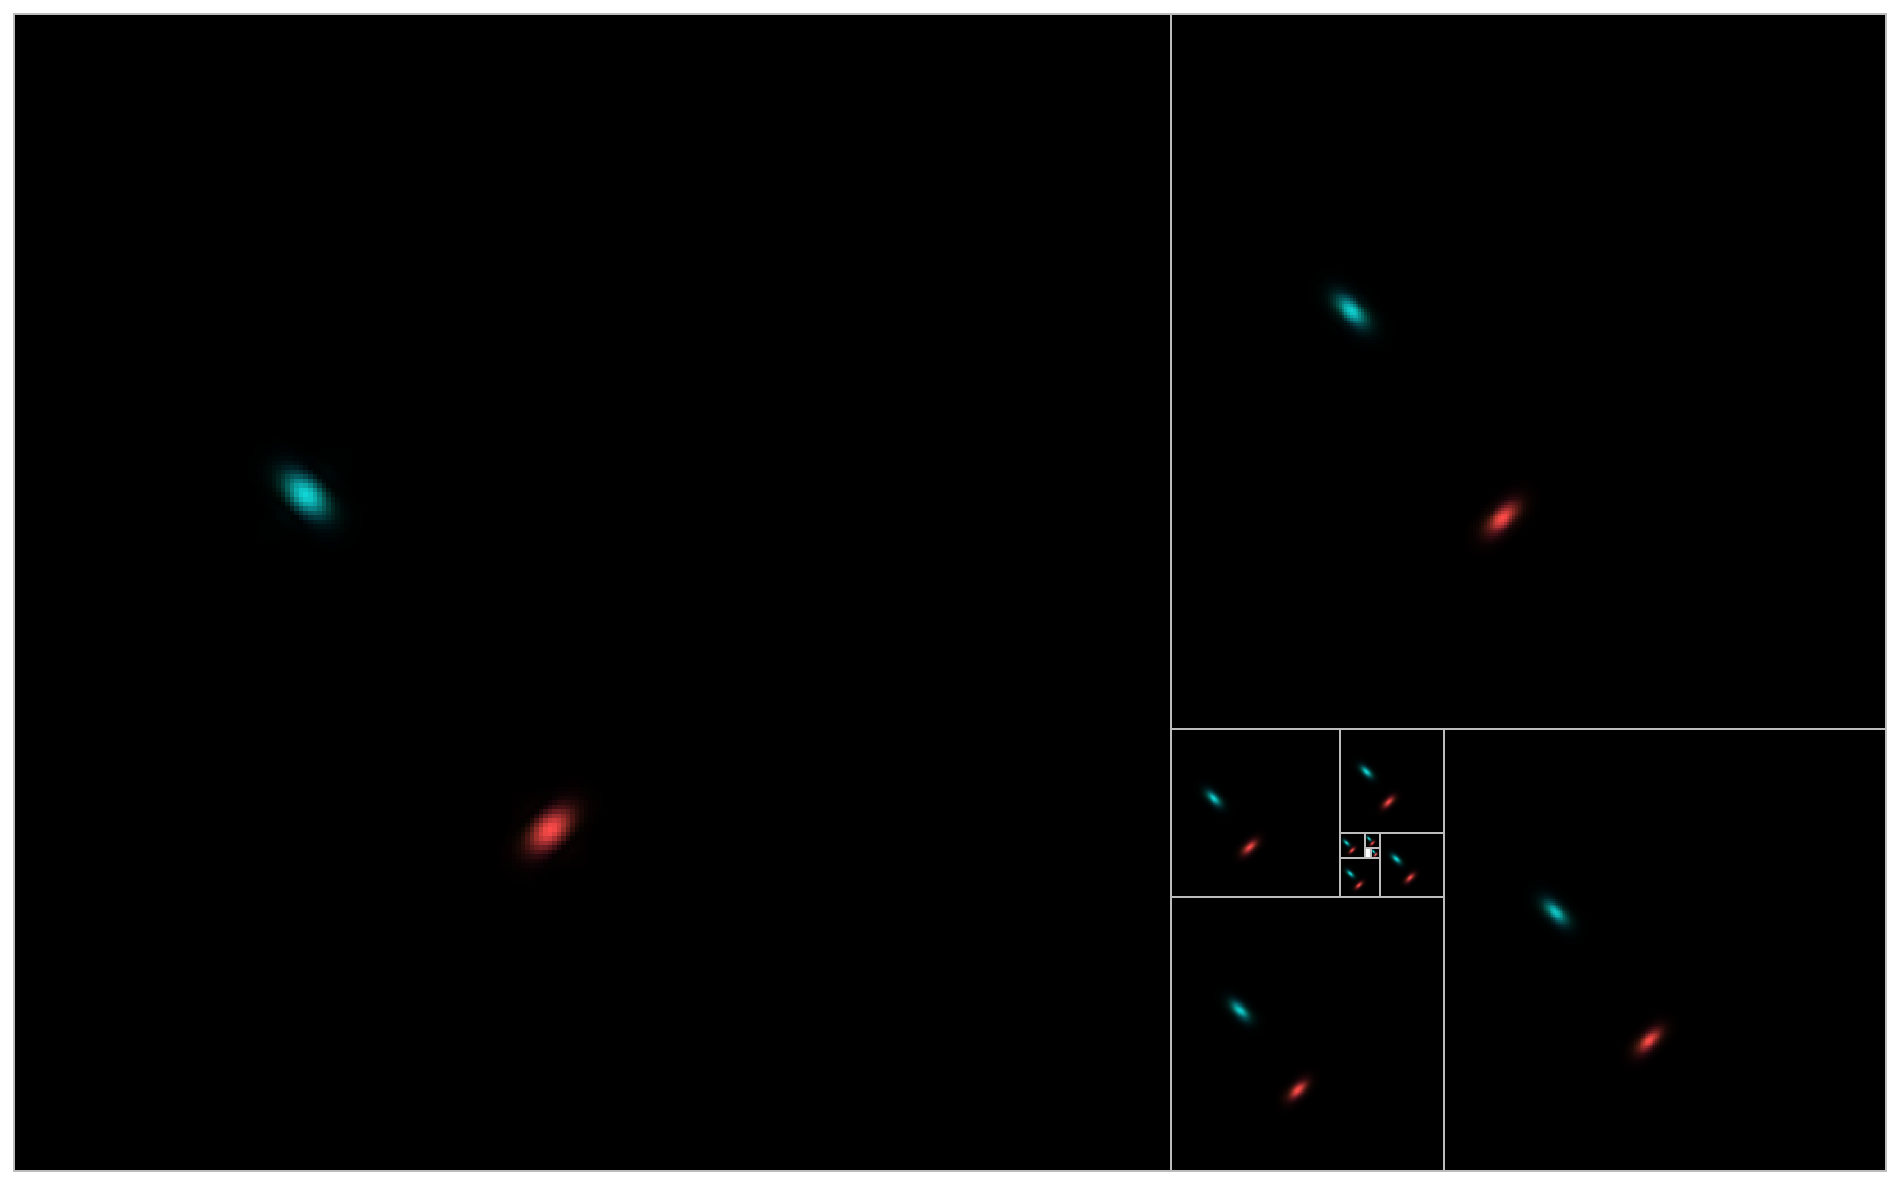

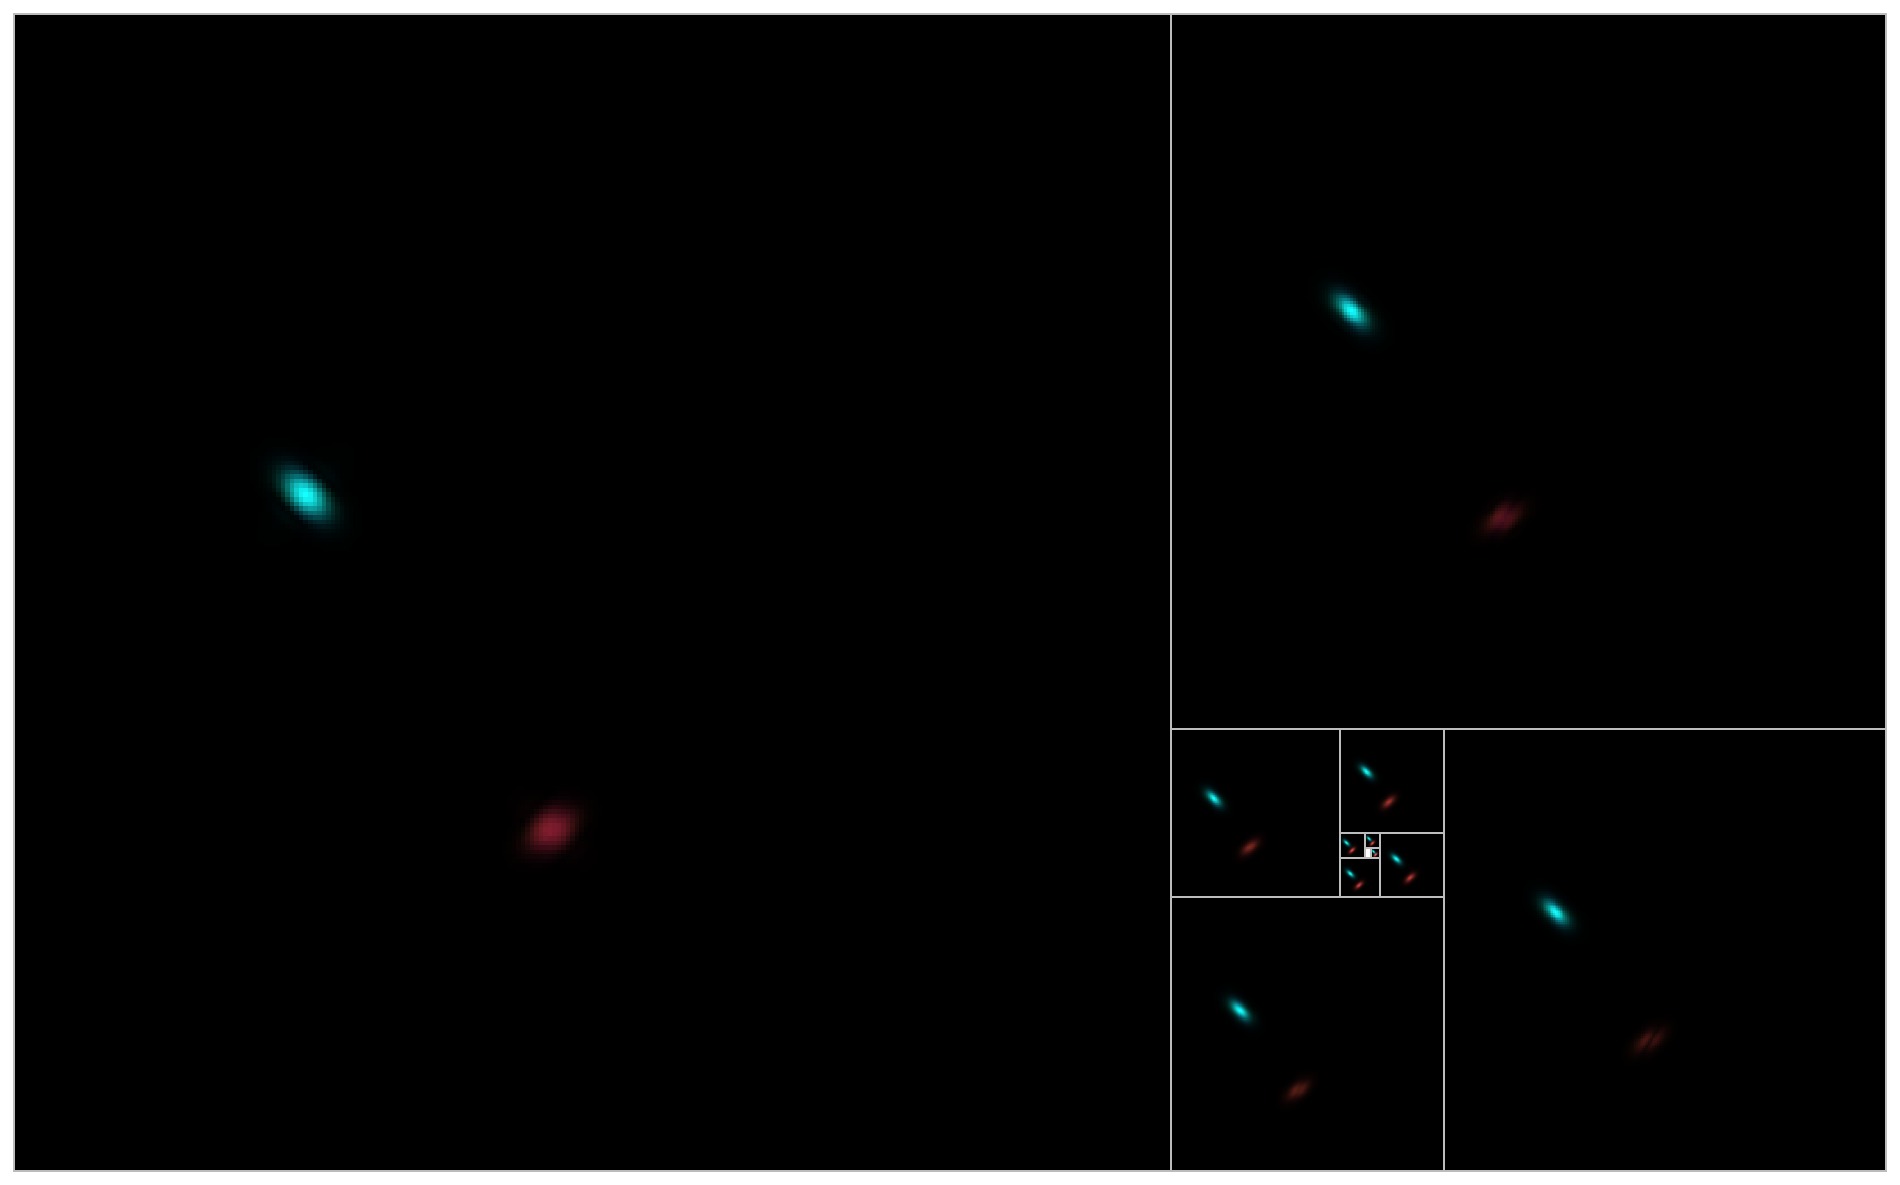

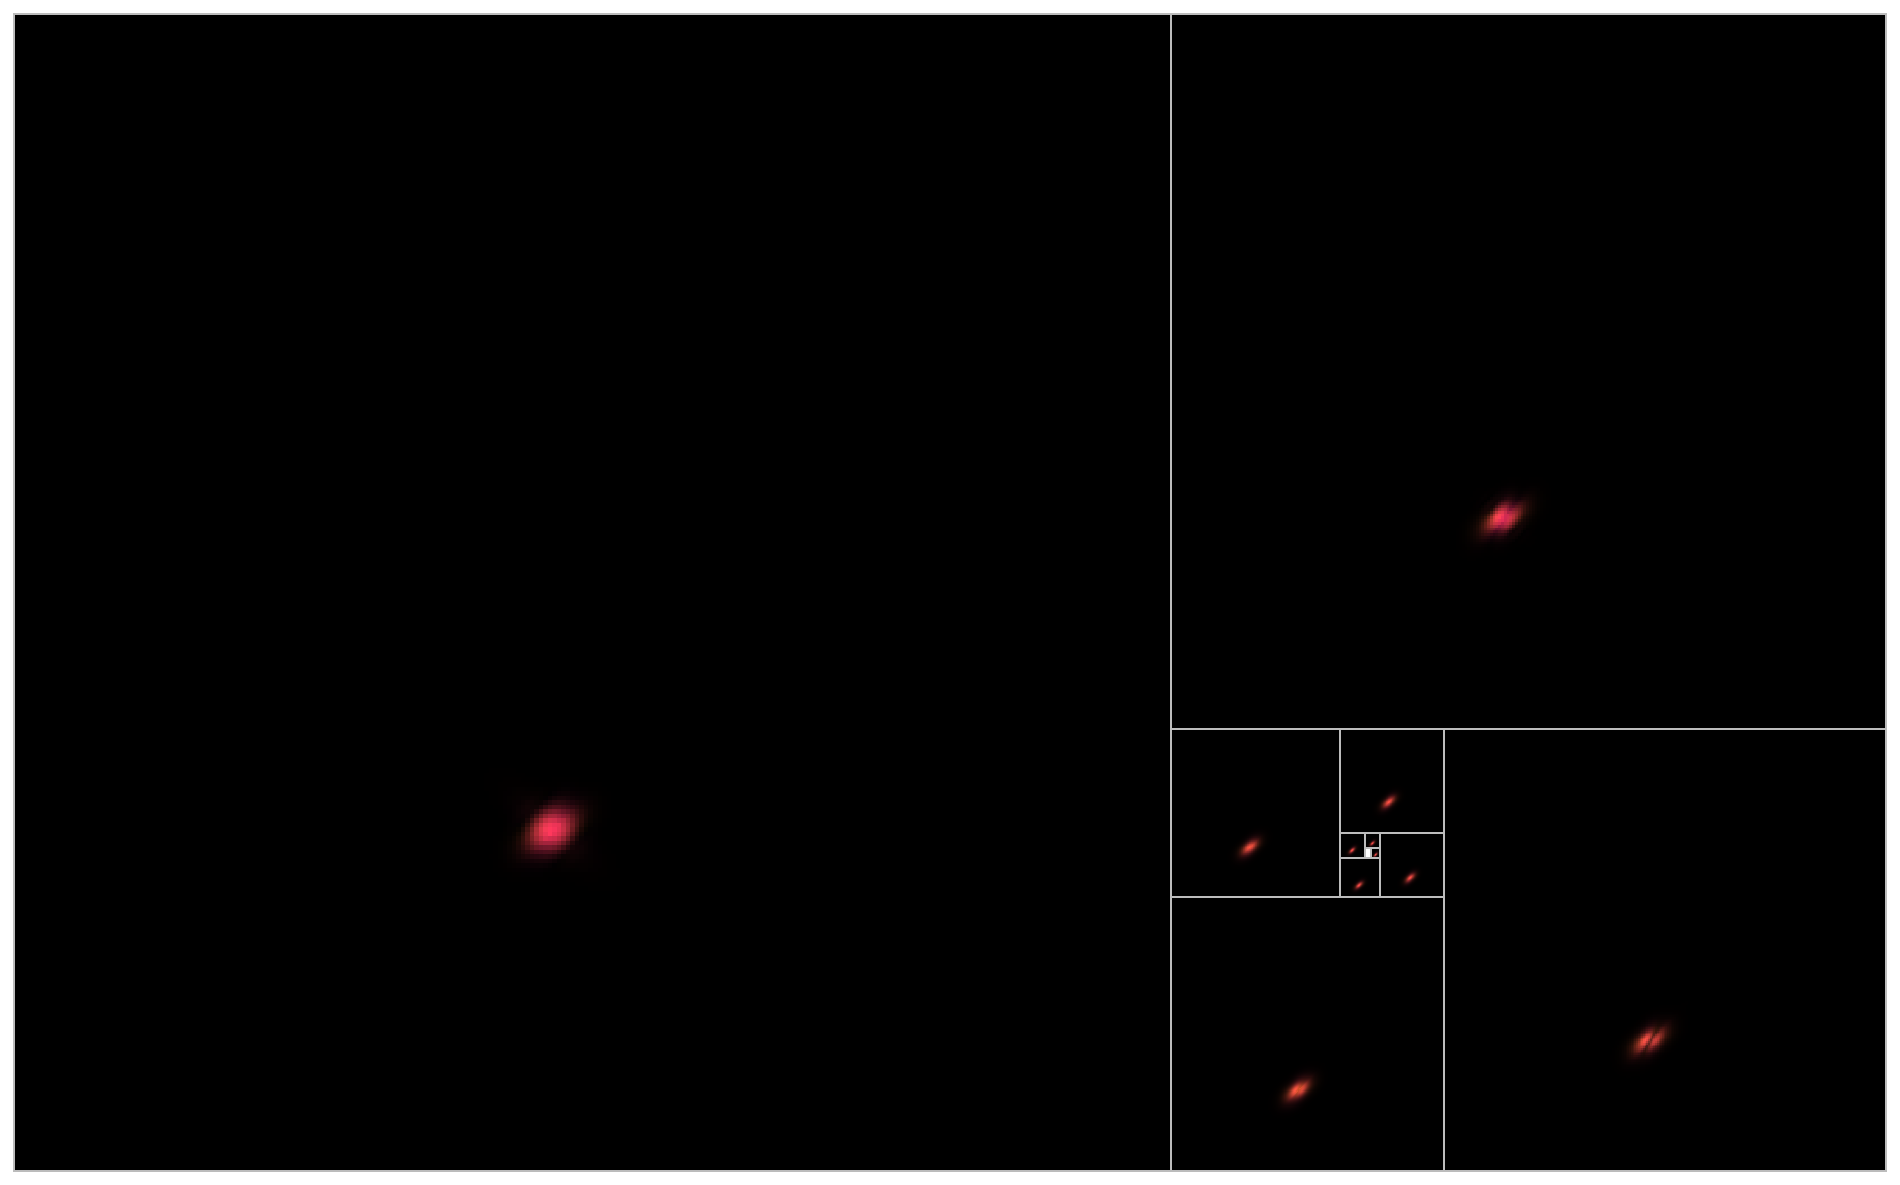

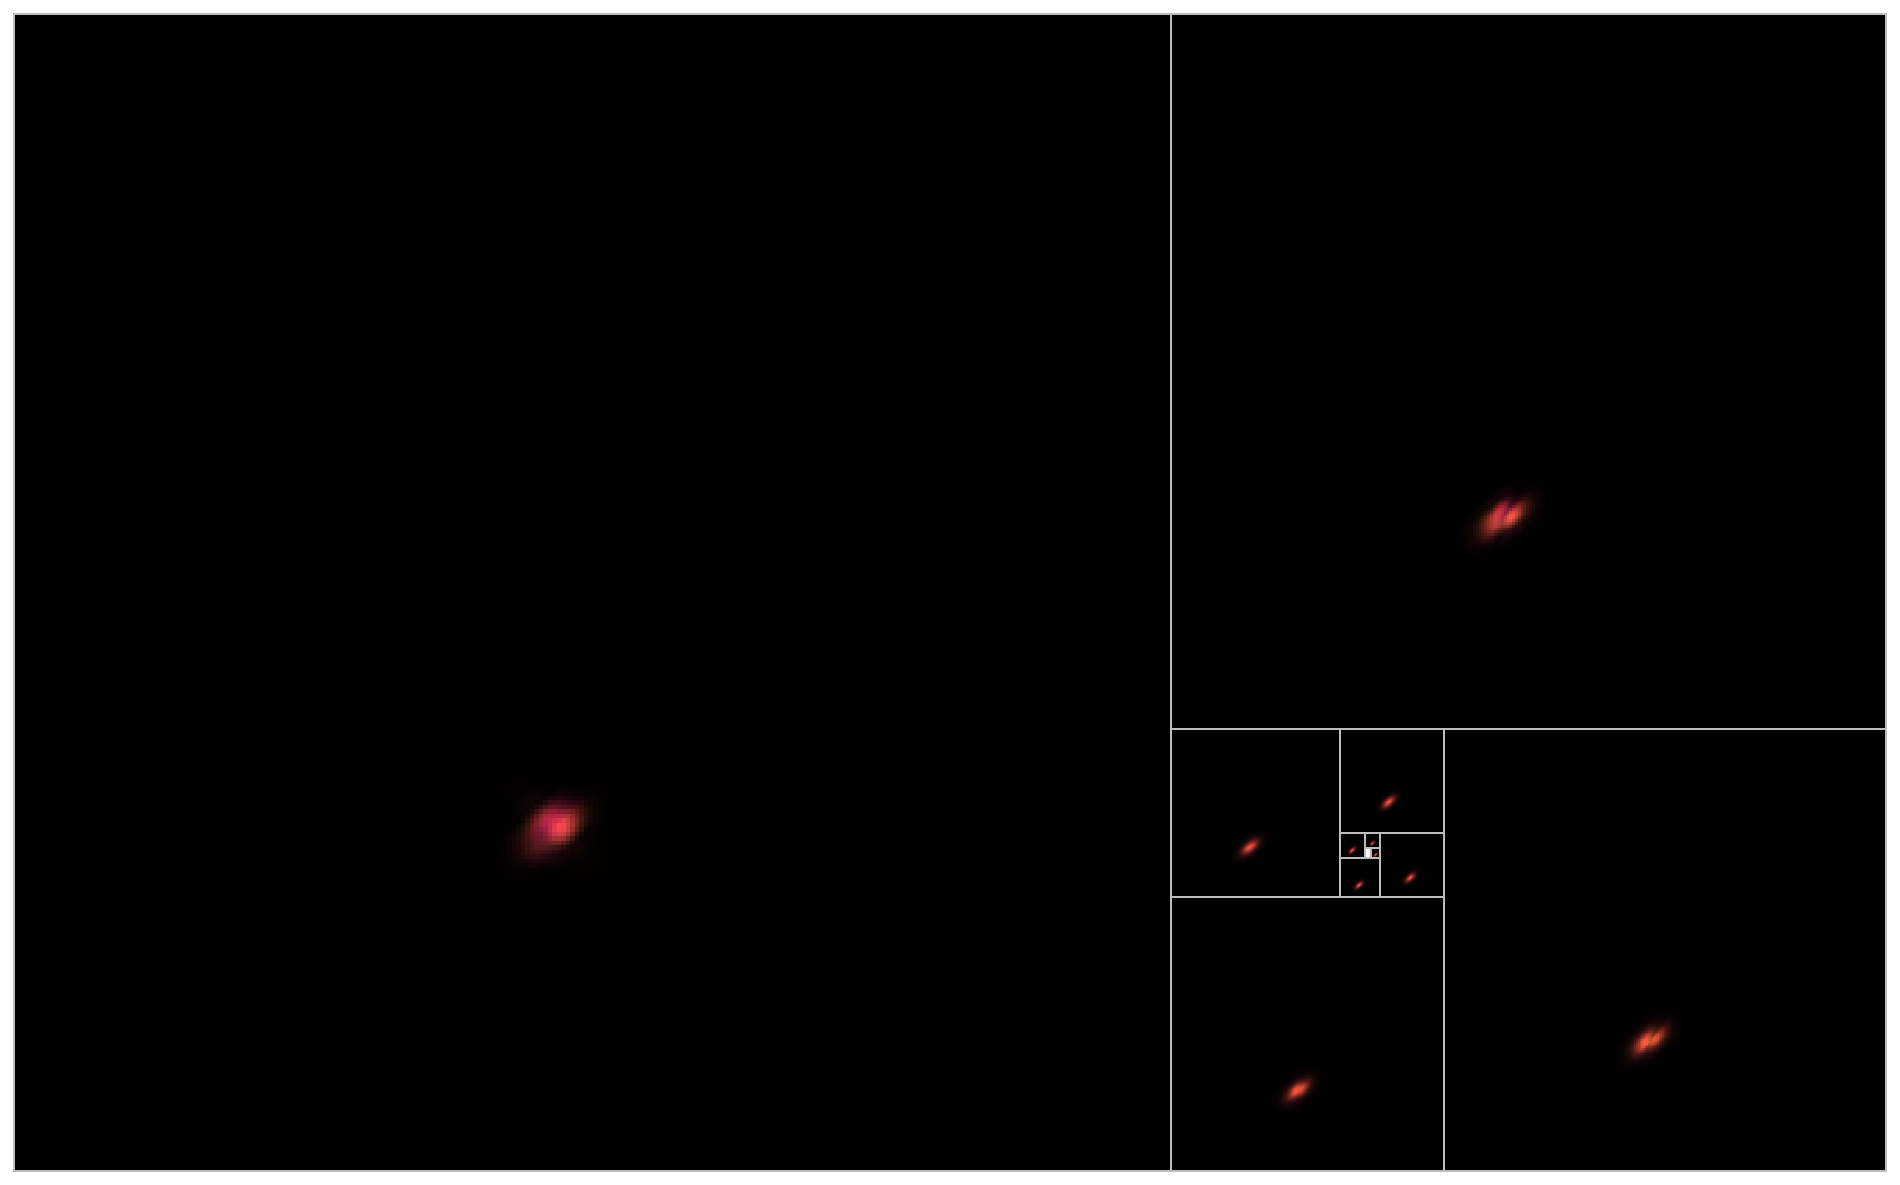

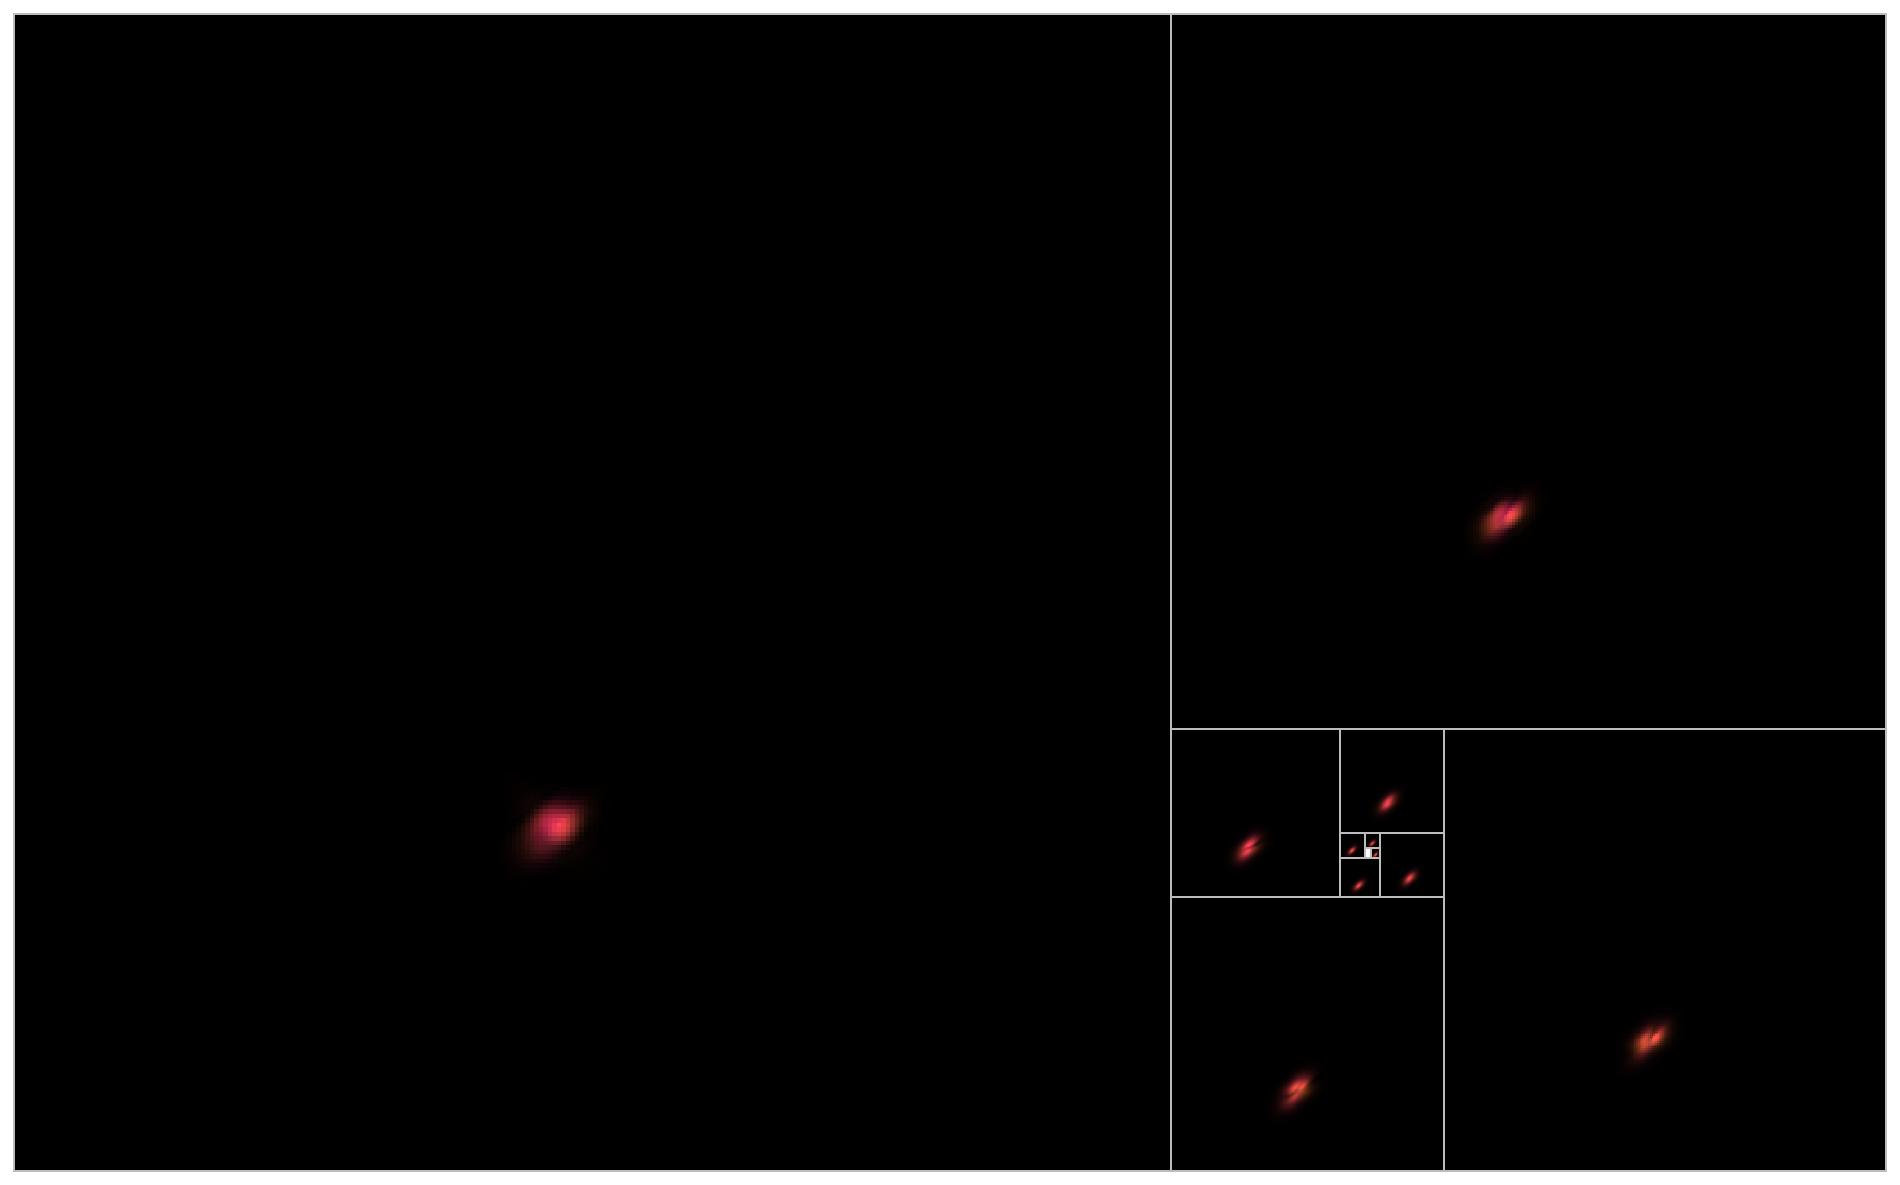

In [14]:
mp.pe.eta_SO = .01
self = mp
C = self.init_C(image)
logD = np.zeros((self.N_X, self.N_Y, self.pe.n_theta, self.n_levels))#, dtype=np.complex)
for i_edge in range(5):
    # MATCHING
    ind_edge_star = self.argmax(C * np.exp( self.pe.eta_SO * logD))

    coeff = self.pe.MP_alpha * np.absolute(C[ind_edge_star])
    # recording
    print ('Max activity  : ', np.absolute(C[ind_edge_star]), ' phase= ', np.angle(C[ind_edge_star], deg=True), ' deg,  @ ', ind_edge_star)
    edges[:, i_edge] = np.array([ind_edge_star[0]*1., ind_edge_star[1]*1.,
                             self.theta[ind_edge_star[2]],
                             self.sf_0[ind_edge_star[3]],
                             coeff, np.angle(C[ind_edge_star])])
    # PURSUIT
    if self.pe.eta_SO>0.: logD+= np.absolute(C[ind_edge_star]) * self.dipole(edges[:, i_edge])
    C = self.backprop(C, ind_edge_star)
    fig = self.golden_pyramid(C * np.exp( self.pe.eta_SO * logD))

## Dipole based on the measured statistics

In [15]:

mp = SparseEdges('https://raw.githubusercontent.com/meduz/SparseEdges/master/default_param.py')
#edgeslist = np.load('mat/edges/prior_vanilla_serre07_distractors_edges.npy')
#edgeslist = np.load('mat/edges/efficiency_B_sf_0_5_serre07_distractors_edges.npy')
edgeslist = np.load('mat/edges/SparseLets_serre07_distractors_edges.npy')
v_hist = mp.cohistedges(edgeslist, display=False)
v_hist.mean(), v_hist.shape
mp.pe.d_max = 50.
mp.cohistedges(edgeslist=None, v_hist=v_hist)
    

IOError: [Errno 2] No such file or directory: 'mat/edges/SparseLets_serre07_distractors_edges.npy'

In [ ]:
def plot_dipole():
    D = np.ones((mp.N_X, mp.N_Y, mp.pe.n_theta, mp.n_levels))
    x, y, theta, sf_0, C, phase = mp.N_X/2, mp.N_Y/2, mp.theta[8], mp.sf_0[2], 1, 0.
    d = np.sqrt((mp.X-x)**2+(mp.Y-y)**2)/mp.N_X
    #if mp.pe.scale_invariant: d *= np.sqrt(Sf_0[:, np.newaxis]*Sf_0[np.newaxis, :])#*np.sqrt(self.N_X)
    d *= mp.pe.d_width # distance in visual angle
    i_d = np.floor((d - mp.pe.d_min)/(mp.pe.d_max-mp.pe.d_min)*mp.pe.N_r)
    #print mp.pe.d_min, i_d.min(), i_d.mean(), i_d.max(), mp.pe.d_max
    i_d = i_d * (i_d>=0)
    #print mp.pe.d_min, i_d.min(), i_d.mean(), i_d.max(), mp.pe.d_max
    i_d = i_d * (i_d<mp.pe.N_r) + (mp.pe.N_r-1) * (i_d >= mp.pe.N_r)
    #print mp.pe.d_min, i_d.min(), i_d.mean(), i_d.max(), mp.pe.d_max

    for i_sf_0, sf_0_ in enumerate(mp.sf_0):
        loglevel = np.log2(sf_0_/sf_0)
        i_loglevel = np.floor((loglevel + mp.pe.loglevel_max)/(mp.pe.loglevel_max*2)*mp.pe.N_scale)* np.ones_like(i_d)
        print( i_loglevel.min(), i_loglevel.mean(), i_loglevel.max())

        for ii_theta, theta_ in enumerate(mp.theta):
            D_theta = theta - theta_ # angle between edge's orientation and the layer's one
            phi = np.arctan2(mp.Y-y, mp.X-x) - np.pi/2 - theta_ - D_theta/2
            # putting everything in the [-pi/2, pi/2[ quadrant
            theta = ((D_theta + np.pi/2 - np.pi/mp.pe.n_theta/2)  % (np.pi) ) - np.pi/2  + np.pi/mp.pe.n_theta/2
            phi = ((phi + np.pi/2  - np.pi/mp.pe.N_phi/2 ) % (np.pi)) - np.pi/2  + np.pi/mp.pe.N_phi/2
            # discretizing
            i_theta = np.floor((theta + np.pi/2)/np.pi*mp.pe.n_theta) * np.ones_like(i_d)
            i_theta = i_theta * (1-(i_theta == mp.pe.n_theta)) + 0. * (i_theta == mp.pe.n_theta)
            i_phi = np.floor((phi + np.pi/2)/np.pi*mp.pe.N_phi)
            #print 1-(i_phi == mp.pe.N_phi)
            i_phi = i_phi * (1-(i_phi == mp.pe.N_phi)) + 0. * (i_phi == mp.pe.N_phi)
            #print i_d.max(), i_phi.max(), i_theta.max(), i_loglevel.max()
            #print i_d.shape, i_phi.shape, i_theta.shape, i_loglevel.shape
            #print type(i_d), type(i_phi), type(i_theta), type(i_loglevel)
            #print ii_theta, i_sf_0, theta_
            D[:, :, ii_theta, i_sf_0] = v_hist[i_d.astype(int), i_phi.astype(int), i_theta.astype(int), i_loglevel.astype(int)]

    
    im_RGB, im_max = [], 0
    for i_sf_0, sf_0_ in enumerate(mp.sf_0):
        im_RGB_ = np.zeros((mp.N_X, mp.N_Y, 3))
        for i_theta, theta_ in enumerate(mp.theta):
            im_abs = np.absolute(D[:, :, i_theta, i_sf_0])
            RGB = np.array([.5*np.sin(2*theta_ + 2*i*np.pi/3)+.5 for i in range(3)])
            im_RGB_ += im_abs[:,:, np.newaxis] * RGB[np.newaxis, np.newaxis, :]

        im_max = np.max((im_max, im_RGB_.max()))
        im_RGB.append(im_RGB_)
       
    phi = (np.sqrt(5) +1.)/2. # golden number
    opts= {'vmin':0., 'vmax':1., 'interpolation':'nearest', 'origin':'upper'}
    fig_width = 16
    fig = plt.figure(figsize=(fig_width, fig_width/phi))
    xmin, ymin, size = 0, 0, 1.
    
    for i_sf_0, sf_0_ in enumerate(mp.sf_0):
        a = fig.add_axes((xmin/phi, ymin, size/phi, size), axisbg='w')
        a.axis(c='b', lw=0)
        plt.setp(a, xticks=[])
        plt.setp(a, yticks=[])
        a.imshow(im_RGB[i_sf_0]/im_max, **opts)
        a.grid(False)
        i_orientation = np.mod(i_sf_0, 4)
        if i_orientation==0:
            xmin += size
            ymin += size/phi**2
        elif i_orientation==1:
            xmin += size/phi**2
            ymin += -size/phi
        elif i_orientation==2:
            xmin += -size/phi
        elif i_orientation==3:
            ymin += size
        size /= phi 

plot_dipole()
#from IPython.html.widgets import interact
#_ = interact(plot_dipole, w=(pe.N_X*.01,pe.N_X,pe.N_X*.01), B_phi=(0.01, 2., 0.04), B_theta=(0.01, 2., 0.04), scale=(0.01, 2., 0.04))

In [ ]:
ind = np.array([[0, 0], [1, 2]])
v_hist[ind, ind, ind, ind]

## Application to segmentation

In [ ]:
mp.pe.N, N_circle, N_image = 1024, 36, 1
edgeslist = np.zeros((6, mp.pe.N+N_circle, N_image))
# random edges:
edgeslist[0, :mp.pe.N, :] = mp.N_X * np.random.rand(mp.pe.N, N_image)
edgeslist[1, :mp.pe.N, :] = mp.N_X * np.random.rand(mp.pe.N, N_image)
edgeslist[2, :mp.pe.N, :] = (np.pi* np.random.rand(mp.pe.N, N_image) ) % np.pi
edgeslist[3, :mp.pe.N, :] = 0.5 * (1- mp.pe.base_levels**(-mp.n_levels*(np.random.rand(mp.pe.N, N_image))))
edgeslist[4, :mp.pe.N, :] = 1.2*np.random.rand(mp.pe.N, N_image) * np.sign(np.random.randn(mp.pe.N, N_image))
edgeslist[5, :mp.pe.N, :] = 2*np.pi*np.random.rand(mp.pe.N, N_image)
# cocircular edges:
for i_N, angle in enumerate(np.linspace(0, 2*np.pi, N_circle)): #2*np.pi*np.random.rand(N_circle)):
    edgeslist[0, mp.pe.N + i_N, :] = mp.N_X/2. - mp.N_X/4.*np.sin(angle) + .0 * np.random.randn(N_image)
    edgeslist[1, mp.pe.N + i_N, :] = mp.N_X/2. + mp.N_X/4.*np.cos(angle) + .0 * np.random.randn(N_image)
    edgeslist[2, mp.pe.N + i_N, :] = (np.pi/2 + angle + .5*np.pi/180 * np.random.randn(N_image)) % np.pi
    edgeslist[3, mp.pe.N + i_N, :] = mp.sf_0[2] #0.03
    edgeslist[4, mp.pe.N + i_N, :] = .7 + .4*np.exp(np.cos(angle)/1.**2)

#print edgeslist.shape
#image_rec = mp.reconstruct(edgeslist[:,:,0])
#from pylab import imsave, gray
#imsave(fname='database/circle_in_noise.png', arr=image_rec, vmin=image_rec.min(), vmax=image_rec.max(), cmap=gray())

mp.pe.scale = 1.7
mp.pe.line_width = 1.5

fig, a = mp.show_edges(edgeslist[:,:,0], image=image, color='toto', show_phase=False) #

In [ ]:
%%writefile test/experiment_fig-secondorder_Geisler.py
# -*- coding: utf8 -*-
from __future__ import division, print_function

# rm **/Geisler01Fig7A_secondorder*
# rm **/circle_in_noise_secondorder*

import os
import numpy as np
import matplotlib.pyplot as plt

from SparseEdges import SparseEdges

#figpath = '../../CNRS/BICV-book/BICV_sparse/'
figpath = './'
FORMATS = ['pdf', 'eps']
fig_width_pt = 318.670  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
fig_width = fig_width_pt*inches_per_pt  # width in inches


def init_mp():
    mp = SparseEdges('https://raw.githubusercontent.com/meduz/SparseEdges/master/default_param.py')
    mp.pe.N = 60
    mp.pe.do_whitening = True
    mp.pe.MP_alpha = 1.
    mp.pe.figsize_edges = 12
    mp.pe.figsize_edges = .382 * fig_width
    mp.pe.scale = 1.3
    mp.pe.line_width = 1.5
    return mp

mp = init_mp()
eta_SO = 0.15

##############################################################################################################
figname = 'Geisler01Fig7A_rec'
if os.path.isfile('database/' + figname + '.png'):
    # defining input image 
    from pylab import imread
    image = imread('database/' + figname + '.png').mean(axis=-1)
    print (image.mean(), image.std())
else:
    N, N_circle, N_image = 1024, 36, 1
    edgeslist = np.zeros((6, N+N_circle, N_image))
    np.random.seed(seed=42)
    # random edges:
    edgeslist[0, :N, :] = mp.N_X * np.random.rand(N, N_image)
    edgeslist[1, :N, :] = mp.N_X * np.random.rand(N, N_image)
    edgeslist[2, :N, :] = (np.pi* np.random.rand(N, N_image) ) % np.pi
    edgeslist[3, :N, :] = 0.5 * (1- mp.pe.base_levels**(-mp.n_levels*(np.random.rand(N, N_image))))
    edgeslist[4, :N, :] = 1.25*np.random.rand(N, N_image) * np.sign(np.random.randn(N, N_image))
    edgeslist[5, :N, :] = 2*np.pi*np.random.rand(N, N_image)
    # cocircular edges:
    for i_N, angle in enumerate(np.linspace(0, 2*np.pi, N_circle)): #2*np.pi*np.random.rand(N_circle)):
        edgeslist[0, N + i_N, :] = mp.N_X/2. - mp.N_X/4.*np.sin(angle) + .0 * np.random.randn(N_image)
        edgeslist[1, N + i_N, :] = mp.N_X/2. + mp.N_X/4.*np.cos(angle) + .0 * np.random.randn(N_image)
        edgeslist[2, N + i_N, :] = (np.pi/2 + angle + .5*np.pi/180 * np.random.randn(N_image)) % np.pi
        edgeslist[3, N + i_N, :] = mp.sf_0[2] #0.03
        edgeslist[4, N + i_N, :] = 1.1 + .15*np.exp(np.cos(angle)/1.**2)

    print (edgeslist.shape)
    image = mp.reconstruct(edgeslist[:,:,0])
    #from pylab import imsave, gray
    #imsave(fname='database/' + figname + '.png', arr=image, vmin=image.min(), vmax=image.max(), cmap=gray())

image = mp.normalize(image, center=True)
print (image.mean(), image.std())
v_max = 1.*image.max()
v_min = -v_max
##############################################################################################################
print( ' without edges ')
matname = 'mat/' + figname + '_secondorder_A.npy'
try:
    fig, a = mp.show_edges(edges=np.zeros((6,0)), image=image, v_min=v_min, v_max=v_max, color='toto', show_phase=False) #
    if not(figpath==None): 
        for ext in FORMATS: 
                fig.savefig(matname.replace('mat/', mp.pe.figpath).replace('.npy', '.' + ext), dpi=450)
    fig.show()
except:
    print ('File ', matname, ' is locked')
##############################################################################################################
print (' without second-order ')
matname = 'mat/' + figname + '_secondorder_B.npy'
if not(os.path.isfile(matname)):
    if not(os.path.isfile(matname + '_lock')):
        file(matname + '_lock', 'w').close()
        mp.pe.eta_SO = 0.
        edges, C_res = mp.run_mp(image, verbose=True)
        np.save(matname, edges)
        os.remove(matname + '_lock')
try:
    edges = np.load(matname)
    fig, a = mp.show_edges(edges, image=image, v_min=v_min, v_max=v_max, color='toto', show_phase=False) #
    if not(figpath==None): 
        for ext in FORMATS: 
                fig.savefig(matname.replace('mat/', mp.pe.figpath).replace('.npy', '.' + ext), dpi=450)
    fig.show()
except:
    print ('File ', matname, ' is locked')
##############################################################################################################
print (' with second-order ')
matname = 'mat/' + figname + '_secondorder_C.npy'
if not(os.path.isfile(matname)):
    if not(os.path.isfile(matname + '_lock')):
        file(matname + '_lock', 'w').close()
        mp.pe.eta_SO = eta_SO
        edges, C_res = mp.run_mp(image, verbose=True)
        np.save(matname, edges)
        os.remove(matname + '_lock')
try:
    edges = np.load(matname)
    edges[4, :] *= -1 # turn red in blue...
    fig, a = mp.show_edges(edges, image=image, v_min=v_min, v_max=v_max, color='toto', show_phase=False) #
    fig.show()
    if not(figpath==None): 
        for ext in FORMATS: 
                fig.savefig(matname.replace('mat/', mp.pe.figpath).replace('.npy', '.' + ext), dpi=450)
except:
    print ('File ', matname, ' is locked')
##############################################################################################################
if True:
    N_explore = 25
    base = 1.5
    ##############################################################################################################
    mp = init_mp()
    for mp.pe.eta_SO in np.logspace(-1., 1., N_explore, base=base)*eta_SO:
        matname = 'mat/' + figname + '_secondorder_eta_SO_' + str(mp.pe.eta_SO).replace('.', '_') + '.npy'
        if not(os.path.isfile(matname)):
            if not(os.path.isfile(matname + '_lock')):
                file(matname + '_lock', 'w').close()
                edges, C_res = mp.run_mp(image, verbose=True)
                np.save(matname, edges)
                os.remove(matname + '_lock')
        try:
            edges = np.load(matname)
            edges[4, :] *= -1 # turn red in blue...
            fig, a = mp.show_edges(edges, image=image, v_min=v_min, v_max=v_max, color='toto', show_phase=False) #
            fig.savefig(matname.replace('mat/', mp.pe.figpath).replace('.npy', '.pdf'))
        except:
            print ('File ', matname, ' is locked')
        plt.close('all')
    ##############################################################################################################
    mp = init_mp()
    mp.pe.eta_SO = eta_SO
    for mp.pe.dip_epsilon in np.linspace(0, 1., N_explore):
        matname = 'mat/' + figname + '_secondorder_dip_epsilon_' + str(mp.pe.dip_epsilon).replace('.', '_') + '.npy'
        if not(os.path.isfile(matname)):
            if not(os.path.isfile(matname + '_lock')):
                file(matname + '_lock', 'w').close()
                edges, C_res = mp.run_mp(image, verbose=True)
                np.save(matname, edges)
                os.remove(matname + '_lock')
        try:
            edges = np.load(matname)
            edges[4, :] *= -1 # turn red in blue...
            fig, a = mp.show_edges(edges, image=image, v_min=v_min, v_max=v_max, color='toto', show_phase=False) #
            fig.savefig(matname.replace('mat/', mp.pe.figpath).replace('.npy', '.pdf'))
        except:
            print ('File ', matname, ' is locked')
        plt.close('all')       
    ##############################################################################################################
    base = 2.
    ##############################################################################################################
    mp = init_mp()
    mp.pe.eta_SO = eta_SO
    for mp.pe.dip_w in np.logspace(-1., 1., N_explore, base=base)*mp.pe.dip_w:
        matname = 'mat/' + figname + '_secondorder_dip_w_' + str(mp.pe.dip_w).replace('.', '_') + '.npy'
        if not(os.path.isfile(matname)):
            if not(os.path.isfile(matname + '_lock')):
                file(matname + '_lock', 'w').close()
                edges, C_res = mp.run_mp(image, verbose=True)
                np.save(matname, edges)
                os.remove(matname + '_lock')
        try:
            edges = np.load(matname)
            edges[4, :] *= -1 # turn red in blue...
            fig, a = mp.show_edges(edges, image=image, v_min=v_min, v_max=v_max, color='toto', show_phase=False) #
            fig.savefig(matname.replace('mat/', mp.pe.figpath).replace('.npy', '.pdf'))
        except:
            print ('File ', matname, ' is locked')
        plt.close('all')
    ##############################################################################################################
    mp = init_mp()
    mp.pe.eta_SO = eta_SO
    for mp.pe.dip_B_psi in np.logspace(-1., 1., N_explore, base=base)*mp.pe.dip_B_psi:
        matname = 'mat/' + figname + '_secondorder_dip_B_psi_' + str(mp.pe.dip_B_psi).replace('.', '_') + '.npy'
        if not(os.path.isfile(matname)):
            if not(os.path.isfile(matname + '_lock')):
                file(matname + '_lock', 'w').close()
                edges, C_res = mp.run_mp(image, verbose=True)
                np.save(matname, edges)
                os.remove(matname + '_lock')
        try:
            edges = np.load(matname)
            edges[4, :] *= -1 # turn red in blue...
            fig, a = mp.show_edges(edges, image=image, v_min=v_min, v_max=v_max, color='toto', show_phase=False) #
            fig.savefig(matname.replace('mat/', mp.pe.figpath).replace('.npy', '.pdf'))
        except:
            print ('File ', matname, ' is locked')
        plt.close('all')
    ##############################################################################################################
    mp = init_mp()
    mp.pe.eta_SO = eta_SO
    for mp.pe.dip_B_theta in np.logspace(-1., 1., N_explore, base=base)*mp.pe.dip_B_theta:
        matname = 'mat/' + figname + '_secondorder_dip_B_theta_' + str(mp.pe.dip_B_theta).replace('.', '_') + '.npy'
        if not(os.path.isfile(matname)):
            if not(os.path.isfile(matname + '_lock')):
                file(matname + '_lock', 'w').close()
                edges, C_res = mp.run_mp(image, verbose=True)
                np.save(matname, edges)
                os.remove(matname + '_lock')
        try:
            edges = np.load(matname)
            edges[4, :] *= -1 # turn red in blue...
            fig, a = mp.show_edges(edges, image=image, v_min=v_min, v_max=v_max, color='toto', show_phase=False) #
            fig.savefig(matname.replace('mat/', mp.pe.figpath).replace('.npy', '.pdf'))
        except:
            print( 'File ', matname, ' is locked')
        plt.close('all')
    ##############################################################################################################
    mp = init_mp()
    mp.pe.eta_SO = eta_SO
    for mp.pe.dip_scale in np.logspace(-1., 1., N_explore, base=base)*mp.pe.dip_scale:
        matname = 'mat/' + figname + '_secondorder_dip_scale_' + str(mp.pe.dip_scale).replace('.', '_') + '.npy'
        if not(os.path.isfile(matname)):
            if not(os.path.isfile(matname + '_lock')):
                file(matname + '_lock', 'w').close()
                edges, C_res = mp.run_mp(image, verbose=True)
                np.save(matname, edges)
                os.remove(matname + '_lock')
        try:
            edges = np.load(matname)
            edges[4, :] *= -1 # turn red in blue...
            fig, a = mp.show_edges(edges, image=image, v_min=v_min, v_max=v_max, color='toto', show_phase=False) #
            fig.savefig(matname.replace('mat/', mp.pe.figpath).replace('.npy', '.pdf'))
        except:
            print ('File ', matname, ' is locked')
        plt.close('all')
    ##############################################################################################################


In [ ]:
%cd test
%run experiment_fig-secondorder_Geisler.py
%cd ..

In [ ]:
%%writefile test/experiment_fig-secondorder_segmentation.py

# rm **/Geisler01Fig7A_secondorder*
# rm **/circle_in_noise_secondorder*

import os
import numpy as np
import matplotlib.pyplot as plt

from SparseEdges import SparseEdges

#figpath = '../../CNRS/BICV-book/BICV_sparse/'
figpath = './'
FORMATS = ['pdf', 'eps']
fig_width_pt = 318.670  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
fig_width = fig_width_pt*inches_per_pt  # width in inches


def init_mp():
    mp = SparseEdges('https://raw.githubusercontent.com/meduz/SparseEdges/master/default_param.py')
    mp.pe.N = 60
    mp.pe.do_whitening = True
    mp.pe.MP_alpha = 1.
    mp.pe.figsize_edges = 12
    mp.pe.figsize_edges = .382 * fig_width
    mp.pe.scale = 1.3
    mp.pe.line_width = 1.5
    return mp

mp = init_mp()
eta_SO = 0.15

##############################################################################################################
figname = 'circle_in_noise'
if os.path.isfile('database/' + figname + '.png'):
    # defining input image 
    from pylab import imread
    image = imread('database/' + figname + '.png').mean(axis=-1)
    print (image.mean(), image.std())
else:
    N, N_circle, N_image = 1024, 36, 1
    edgeslist = np.zeros((6, N+N_circle, N_image))
    np.random.seed(seed=42)
    # random edges:
    edgeslist[0, :N, :] = mp.N_X * np.random.rand(N, N_image)
    edgeslist[1, :N, :] = mp.N_X * np.random.rand(N, N_image)
    edgeslist[2, :N, :] = (np.pi* np.random.rand(N, N_image) ) % np.pi
    edgeslist[3, :N, :] = 0.5 * (1- mp.pe.base_levels**(-mp.n_levels*(np.random.rand(N, N_image))))
    edgeslist[4, :N, :] = 1.25*np.random.rand(N, N_image) * np.sign(np.random.randn(N, N_image))
    edgeslist[5, :N, :] = 2*np.pi*np.random.rand(N, N_image)
    # cocircular edges:
    for i_N, angle in enumerate(np.linspace(0, 2*np.pi, N_circle)): #2*np.pi*np.random.rand(N_circle)):
        edgeslist[0, N + i_N, :] = mp.N_X/2. - mp.N_X/4.*np.sin(angle) + .0 * np.random.randn(N_image)
        edgeslist[1, N + i_N, :] = mp.N_X/2. + mp.N_X/4.*np.cos(angle) + .0 * np.random.randn(N_image)
        edgeslist[2, N + i_N, :] = (np.pi/2 + angle + .5*np.pi/180 * np.random.randn(N_image)) % np.pi
        edgeslist[3, N + i_N, :] = mp.sf_0[2] #0.03
        edgeslist[4, N + i_N, :] = 1.1 + .15*np.exp(np.cos(angle)/1.**2)

    print (edgeslist.shape)
    image = mp.reconstruct(edgeslist[:,:,0])
    #from pylab import imsave, gray
    #imsave(fname='database/' + figname + '.png', arr=image, vmin=image.min(), vmax=image.max(), cmap=gray())

image = mp.normalize(image, center=True)
print (image.mean(), image.std())
v_max = 1.*image.max()
v_min = -v_max
##############################################################################################################
print (' without edges ')
matname = 'mat/' + figname + '_secondorder_A.npy'
try:
    fig, a = mp.show_edges(edges=np.zeros((6,0)), image=image, v_min=v_min, v_max=v_max, color='toto', show_phase=False) #
    if not(figpath==None): 
        for ext in FORMATS: 
                fig.savefig(matname.replace('mat/', mp.pe.figpath).replace('.npy', '.' + ext), dpi=450)
    fig.show()
except:
    print( 'File ', matname, ' is locked')
##############################################################################################################
print (' without second-order ')
matname = 'mat/' + figname + '_secondorder_B.npy'
if not(os.path.isfile(matname)):
    if not(os.path.isfile(matname + '_lock')):
        file(matname + '_lock', 'w').close()
        mp.pe.eta_SO = 0.
        edges, C_res = mp.run_mp(image, verbose=True)
        np.save(matname, edges)
        os.remove(matname + '_lock')
try:
    edges = np.load(matname)
    fig, a = mp.show_edges(edges, image=image, v_min=v_min, v_max=v_max, color='toto', show_phase=False) #
    if not(figpath==None): 
        for ext in FORMATS: 
                fig.savefig(matname.replace('mat/', mp.pe.figpath).replace('.npy', '.' + ext), dpi=450)
    fig.show()
except:
    print ('File ', matname, ' is locked')
##############################################################################################################
print (' with second-order ')
matname = 'mat/' + figname + '_secondorder_C.npy'
if not(os.path.isfile(matname)):
    if not(os.path.isfile(matname + '_lock')):
        file(matname + '_lock', 'w').close()
        mp.pe.eta_SO = eta_SO
        edges, C_res = mp.run_mp(image, verbose=True)
        np.save(matname, edges)
        os.remove(matname + '_lock')
try:
    edges = np.load(matname)
    edges[4, :] *= -1 # turn red in blue...
    fig, a = mp.show_edges(edges, image=image, v_min=v_min, v_max=v_max, color='toto', show_phase=False) #
    fig.show()
    if not(figpath==None): 
        for ext in FORMATS: 
                fig.savefig(matname.replace('mat/', mp.pe.figpath).replace('.npy', '.' + ext), dpi=450)
except:
    print( 'File ', matname, ' is locked')
##############################################################################################################
if True:
    N_explore = 25
    base = 1.5
    ##############################################################################################################
    mp = init_mp()
    for mp.pe.eta_SO in np.logspace(-1., 1., N_explore, base=base)*eta_SO:
        matname = 'mat/' + figname + '_secondorder_eta_SO_' + str(mp.pe.eta_SO).replace('.', '_') + '.npy'
        if not(os.path.isfile(matname)):
            if not(os.path.isfile(matname + '_lock')):
                file(matname + '_lock', 'w').close()
                edges, C_res = mp.run_mp(image, verbose=True)
                np.save(matname, edges)
                os.remove(matname + '_lock')
        try:
            edges = np.load(matname)
            edges[4, :] *= -1 # turn red in blue...
            fig, a = mp.show_edges(edges, image=image, v_min=v_min, v_max=v_max, color='toto', show_phase=False) #
            fig.savefig(matname.replace('mat/', mp.pe.figpath).replace('.npy', '.pdf'))
        except:
            print( 'File ', matname, ' is locked')
        plt.close('all')
    ##############################################################################################################
    mp = init_mp()
    mp.pe.eta_SO = eta_SO
    for mp.pe.dip_epsilon in np.linspace(0, 1., N_explore):
        matname = 'mat/' + figname + '_secondorder_dip_epsilon_' + str(mp.pe.dip_epsilon).replace('.', '_') + '.npy'
        if not(os.path.isfile(matname)):
            if not(os.path.isfile(matname + '_lock')):
                file(matname + '_lock', 'w').close()
                edges, C_res = mp.run_mp(image, verbose=True)
                np.save(matname, edges)
                os.remove(matname + '_lock')
        try:
            edges = np.load(matname)
            edges[4, :] *= -1 # turn red in blue...
            fig, a = mp.show_edges(edges, image=image, v_min=v_min, v_max=v_max, color='toto', show_phase=False) #
            fig.savefig(matname.replace('mat/', mp.pe.figpath).replace('.npy', '.pdf'))
        except:
            print( 'File ', matname, ' is locked')
        plt.close('all')       
    ##############################################################################################################
    base = 2.
    ##############################################################################################################
    mp = init_mp()
    mp.pe.eta_SO = eta_SO
    for mp.pe.dip_w in np.logspace(-1., 1., N_explore, base=base)*mp.pe.dip_w:
        matname = 'mat/' + figname + '_secondorder_dip_w_' + str(mp.pe.dip_w).replace('.', '_') + '.npy'
        if not(os.path.isfile(matname)):
            if not(os.path.isfile(matname + '_lock')):
                file(matname + '_lock', 'w').close()
                edges, C_res = mp.run_mp(image, verbose=True)
                np.save(matname, edges)
                os.remove(matname + '_lock')
        try:
            edges = np.load(matname)
            edges[4, :] *= -1 # turn red in blue...
            fig, a = mp.show_edges(edges, image=image, v_min=v_min, v_max=v_max, color='toto', show_phase=False) #
            fig.savefig(matname.replace('mat/', mp.pe.figpath).replace('.npy', '.pdf'))
        except:
            print( 'File ', matname, ' is locked')
        plt.close('all')
    ##############################################################################################################
    mp = init_mp()
    mp.pe.eta_SO = eta_SO
    for mp.pe.dip_B_psi in np.logspace(-1., 1., N_explore, base=base)*mp.pe.dip_B_psi:
        matname = 'mat/' + figname + '_secondorder_dip_B_psi_' + str(mp.pe.dip_B_psi).replace('.', '_') + '.npy'
        if not(os.path.isfile(matname)):
            if not(os.path.isfile(matname + '_lock')):
                file(matname + '_lock', 'w').close()
                edges, C_res = mp.run_mp(image, verbose=True)
                np.save(matname, edges)
                os.remove(matname + '_lock')
        try:
            edges = np.load(matname)
            edges[4, :] *= -1 # turn red in blue...
            fig, a = mp.show_edges(edges, image=image, v_min=v_min, v_max=v_max, color='toto', show_phase=False) #
            fig.savefig(matname.replace('mat/', mp.pe.figpath).replace('.npy', '.pdf'))
        except:
            print( 'File ', matname, ' is locked')
        plt.close('all')
    ##############################################################################################################
    mp = init_mp()
    mp.pe.eta_SO = eta_SO
    for mp.pe.dip_B_theta in np.logspace(-1., 1., N_explore, base=base)*mp.pe.dip_B_theta:
        matname = 'mat/' + figname + '_secondorder_dip_B_theta_' + str(mp.pe.dip_B_theta).replace('.', '_') + '.npy'
        if not(os.path.isfile(matname)):
            if not(os.path.isfile(matname + '_lock')):
                file(matname + '_lock', 'w').close()
                edges, C_res = mp.run_mp(image, verbose=True)
                np.save(matname, edges)
                os.remove(matname + '_lock')
        try:
            edges = np.load(matname)
            edges[4, :] *= -1 # turn red in blue...
            fig, a = mp.show_edges(edges, image=image, v_min=v_min, v_max=v_max, color='toto', show_phase=False) #
            fig.savefig(matname.replace('mat/', mp.pe.figpath).replace('.npy', '.pdf'))
        except:
            print ('File ', matname, ' is locked')
        plt.close('all')
    ##############################################################################################################
    mp = init_mp()
    mp.pe.eta_SO = eta_SO
    for mp.pe.dip_scale in np.logspace(-1., 1., N_explore, base=base)*mp.pe.dip_scale:
        matname = 'mat/' + figname + '_secondorder_dip_scale_' + str(mp.pe.dip_scale).replace('.', '_') + '.npy'
        if not(os.path.isfile(matname)):
            if not(os.path.isfile(matname + '_lock')):
                file(matname + '_lock', 'w').close()
                edges, C_res = mp.run_mp(image, verbose=True)
                np.save(matname, edges)
                os.remove(matname + '_lock')
        try:
            edges = np.load(matname)
            edges[4, :] *= -1 # turn red in blue...
            fig, a = mp.show_edges(edges, image=image, v_min=v_min, v_max=v_max, color='toto', show_phase=False) #
            fig.savefig(matname.replace('mat/', mp.pe.figpath).replace('.npy', '.pdf'))
        except:
            print( 'File ', matname, ' is locked')
        plt.close('all')
    ##############################################################################################################


In [ ]:
%cd test
%run experiment_fig-secondorder_segmentation.py
%cd ..

## showing what happens

In [ ]:
import matplotlib
#matplotlib.rcParams.update({'font.size': 18, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})
matplotlib.rcParams.update({'text.usetex': False})
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt

import numpy as np
np.set_printoptions(precision=4)#, suppress=True)


In [ ]:
mp = SparseEdges('https://raw.githubusercontent.com/meduz/SparseEdges/master/default_param.py')
mp.pe.MP_alpha = 1.
mp.pe.N = 210
mp.pe.N = 105
mp.pe.do_whitening = False
#pe.do_whitening = True


#figpath = '../../CNRS/BICV-book/BICV_INT/BICV-sparse/'
figpath = './'
FORMATS = ['pdf', 'eps']
fig_width_pt = 318.670  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
fig_width = fig_width_pt*inches_per_pt  # width in inches
mp.pe.figsize_edges = 12
mp.pe.figsize_edges = .382 * fig_width
mp.pe.scale = 1.3
mp.pe.line_width = 1.5


# defining input image 
from pylab import imread
image = imread('database/circle_in_noise.png').mean(axis=-1)
print( image.mean(), image.std())

image = mp.normalize(image, center=True)
print (image.mean(), image.std())
v_max = 1.*image.max()
v_min = -v_max

print( mp.n_levels, mp.sf_0)
mp.pe.eta_SO = 0.15

In [ ]:
C = mp.init_C(image)

In [ ]:
fig = mp.golden_pyramid(C)

In [ ]:
self = mp
ind_edge_star = self.argmax(C)
coeff = self.pe.MP_alpha * np.absolute(C[ind_edge_star])
print ('Max activity  : ', np.absolute(C[ind_edge_star]), ' phase= ', np.angle(C[ind_edge_star], deg=True), ' deg,  @ ', ind_edge_star)

In [ ]:
edges = np.zeros((6, self.pe.N))
i_edge = 0
logD = np.zeros((self.N_X, self.N_Y, self.pe.n_theta, self.n_levels))#, dtype=np.complex)
edges[:, i_edge] = np.array([ind_edge_star[0]*1., ind_edge_star[1]*1.,
                                         self.theta[ind_edge_star[2]],
                                         self.sf_0[ind_edge_star[3]],
                                         coeff, np.angle(C[ind_edge_star])])
logD+= np.absolute(C[ind_edge_star]) * self.dipole(edges[:, i_edge])
fig = self.golden_pyramid(logD)

In [ ]:
C = self.backprop(C, ind_edge_star)
fig = self.golden_pyramid(C + self.pe.eta_SO * logD)

In [ ]:
C = mp.init_C(image)
logD = np.zeros((self.N_X, self.N_Y, self.pe.n_theta, self.n_levels))#, dtype=np.complex)
for i_edge in range(60):
    # MATCHING
    ind_edge_star = self.argmax(C * np.exp( self.pe.eta_SO * logD))

    coeff = self.pe.MP_alpha * np.absolute(C[ind_edge_star])
    # recording
    print ('Max activity  : ', np.absolute(C[ind_edge_star]), ' phase= ', np.angle(C[ind_edge_star], deg=True), ' deg,  @ ', ind_edge_star)
    edges[:, i_edge] = np.array([ind_edge_star[0]*1., ind_edge_star[1]*1.,
                             self.theta[ind_edge_star[2]],
                             self.sf_0[ind_edge_star[3]],
                             coeff, np.angle(C[ind_edge_star])])
    # PURSUIT
    if self.pe.eta_SO>0.: logD+= np.absolute(C[ind_edge_star]) * self.dipole(edges[:, i_edge])
    C = self.backprop(C, ind_edge_star)
    fig = self.golden_pyramid(C * np.exp( self.pe.eta_SO * logD))

In [ ]:
image_rec = mp.reconstruct(edges)
print ('RMSE-W = ', ((im.whitening(image)-image_rec)**2).sum()/((im.whitening(image))**2).sum())
fig, a = mp.show_edges(edges, image=image_rec*1.)


### application to a natural image

## some book keeping for the notebook

In [ ]:
%install_ext https://raw.githubusercontent.com/rasbt/python_reference/master/ipython_magic/watermark.py
%load_ext watermark
%watermark

In [ ]:
%install_ext http://raw.github.com/jrjohansson/version_information/master/version_information.py
%load_ext version_information
%version_information numpy, scipy, matplotlib, sympy